In [11]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set_theme(style="whitegrid")


# TensorNetwork class
class TensorNetwork:
    def __init__(self, graph, tensors):
        self.graph = graph
        self.tensors = tensors
        self.index_dims = {}
        self.index_to_tensors = {}

        for name, (tensor, indices) in tensors.items():
            for idx, dim in zip(indices, tensor.shape):
                if idx in self.index_dims:
                    assert self.index_dims[idx] == dim
                else:
                    self.index_dims[idx] = dim
                self.index_to_tensors.setdefault(idx, []).append((name, tensor, indices))

        self.col_of = {idx: i for i, idx in enumerate(self.index_dims)}
    
def naive_mc_estimate(network, num_samples=10000, Z_true=None, seed=None):
    if seed is not None:
        np.random.seed(seed)

    indices = list(network.index_dims)
    dims = [network.index_dims[i] for i in indices]
    all_vals = []

    for _ in range(num_samples):
        x = [np.random.randint(0, dim) for dim in dims]
        config = np.array(x).reshape(1, -1)
        val = evaluate_config(network, config)[0]
        all_vals.append(val)
    
    volume = np.prod(dims)
    mean_val = np.mean(all_vals)
    std_val = np.std(all_vals) / np.sqrt(num_samples)

    estimate = mean_val * volume
    error = std_val * volume

    print(f'Naive MC Estimate of Z: {estimate:.6f} ± {error:.6f}')
    if Z_true:
        relative_error = abs(estimate - Z_true) / abs(Z_true)
        print(f'Relative Error: {relative_error:.6%}')
    
    return estimate, error, all_vals


def evaluate_config(network, configs):
    result = np.ones(len(configs))
    for name, (tensor, inds) in network.tensors.items():
        keys = tuple(configs[:, network.col_of[i]] for i in inds)
        result *= tensor[keys]
    return result


def update_edge(network, configs, idx, beta=1.0):
    dim = network.index_dims[idx]
    col = network.col_of[idx]
    n_chains = configs.shape[0]
    probs = np.ones((n_chains, dim))

    for _, tensor, inds in network.index_to_tensors[idx]:
        slc = [slice(None) if i == idx else configs[:, network.col_of[i]] for i in inds]
        arr_vals = tensor[tuple(slc)]
        if arr_vals.shape != (n_chains, dim):
            arr_vals = arr_vals.T
        probs *= arr_vals ** beta

    probs /= probs.sum(axis=1, keepdims=True)
    configs[:, col] = [np.random.choice(dim, p=probs[i]) for i in range(n_chains)]


def estimate_contraction(net, betas, iters=20000, burns=1900, n_chains=10, verbose=True):
    n_betas = len(betas)
    index_list = list(net.index_dims)
    n_sites = len(index_list)

    # configs = np.random.randint(0, 3, size=(n_chains, n_sites))
    configs = np.tile(np.arange(3), (n_chains, int(np.ceil(n_sites / 3))))[:, :n_sites]
    np.random.shuffle(configs.T)
    logZ_sums = np.zeros(n_chains)
    logZ_trajs = [[] for _ in range(n_chains)]
    weights_by_beta = [[] for _ in range(n_betas - 1)]

    for step in range(1, n_betas):
        beta_prev, beta_curr = betas[step - 1], betas[step]
        delta_beta = beta_curr - beta_prev

        if verbose and (step % 10 == 0 or step == n_betas - 1):
            print(f'[{datetime.now().strftime("%H:%M:%S")}] beta step {step}/{n_betas - 1} ({beta_curr:.4f})')

        chain_weights = [[] for _ in range(n_chains)]

        for t in range(iters):
            idx = np.random.choice(index_list)
            update_edge(net, configs, idx, beta=beta_prev)

            if t >= burns:
                psi_vals = evaluate_config(net, configs)
                weights = np.where(psi_vals > 1e-30, psi_vals ** (delta_beta), 0.0)
                for j in range(n_chains):
                    chain_weights[j].append(weights[j])

        for j in range(n_chains):
            w = chain_weights[j]
            mw = np.mean(w) if w else 0.0
            # log_rho = np.log(mw) if mw > 0 else -np.inf
            log_rho = np.logaddexp.reduce(np.log(w)) - np.log(len(w))
            logZ_sums[j] += log_rho
            logZ_trajs[j].append(logZ_sums[j])
            weights_by_beta[step - 1].append(np.asarray(w))

        if verbose:
            mean_log_rho = np.mean([np.log(np.mean(w)) if np.mean(w) > 0 else -np.inf for w in chain_weights])
            mean_w = np.mean([np.mean(w) for w in chain_weights])
            print(f"[beta={beta_curr:.3f}]  mean log rho = {mean_log_rho:+.3e}  | <w> mean = {mean_w:.4e}")

    log_size = np.sum(np.log(list(net.index_dims.values())))
    Z_ests = np.exp(logZ_sums + log_size)
    return Z_ests, logZ_trajs, weights_by_beta


def run_diagnostics(betas, logZ_trajectories, weights_by_beta, Z_ests, Z_true=None):
    n_chains = len(Z_ests)

    # logZ convergence
    plt.figure(figsize=(12, 3.8))
    for k, traj in enumerate(logZ_trajectories, 1):
        plt.plot(betas[1:], traj, label=f"chain {k}", alpha=0.8)
    plt.xlabel(r"$\beta$")
    plt.ylabel(r"$\log Z$")
    plt.title("log-Z convergence across chains")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # relative std dev of weights
    plt.figure(figsize=(12, 3.8))
    for k in range(n_chains):
        rel_sig = []
        for weights in weights_by_beta:
            w = weights[k]
            rel = np.std(w) / np.mean(w) if np.mean(w) > 0 else 0
            rel_sig.append(rel)
        plt.plot(betas[1:], rel_sig, label=f"chain {k+1}", alpha=0.8)
    plt.xlabel(r"$\beta$")
    plt.ylabel(r"rel $\sigma(w)$")
    plt.title("weight dispersion vs beta")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # log-weight variance
    log_var_per_beta = []
    for beta_weights in weights_by_beta:
        log_vars = [np.var(np.log(np.clip(w, 1e-12, None))) for w in beta_weights]
        log_var_per_beta.append(np.mean(log_vars))

    fig, ax = plt.subplots(figsize=(6.5, 4))
    sns.lineplot(x=betas[1:], y=log_var_per_beta, marker='o', ax=ax)
    ax.axhline(1.0, ls='--', color='gray', label='Variance Threshold')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\beta$')
    ax.set_ylabel(r'Variance of $\log w$')
    ax.set_title("Variance of Log-Weights vs Beta Step")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # error bars
    est_mean, est_std = np.mean(Z_ests), np.std(Z_ests)
    print(rf"\nFinal relative variance of $\hat Z$: {est_std / est_mean:.4e}")

    if Z_true is not None:
        rel_errs = [abs(z - Z_true) / abs(Z_true) for z in Z_ests]
        plt.figure(figsize=(5.5, 4))
        plt.bar(range(1, n_chains + 1), rel_errs)
        plt.xlabel("chain")
        plt.ylabel("rel error")
        plt.title("final relative error per chain")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"True  Z   : {Z_true:.6f}")
        print(f"Mean  Ẑ  : {est_mean:.6f}  ± {est_std:.6f}")
        print(f"Mean rel error: {np.mean(rel_errs):.8%}")


def run_multiple_chains(net, betas, dim=3, n_betas=300, iters=20000, burns=1900, n_chains=10, Z_true=None):
    print(f"Running {n_chains} AIS chains vectorized")
    Z_ests, logZ_trajectories, weights_by_beta = estimate_contraction(
        net, betas, iters, burns, n_chains=n_chains, verbose=True
    )

    run_diagnostics(betas, logZ_trajectories, weights_by_beta, Z_ests, Z_true=Z_true)
    return np.mean(Z_ests), np.std(Z_ests)

In [12]:
def test_trace_ABCD(dim=3,
                    n_betas=200,
                    n_chains=10,
                    iters=20000,
                    burns=10000):
    print("\n>>> Building 2x2 ring tensor network (Tr(ABCD))")

    G = nx.Graph()
    G.add_edges_from([
        ('A', 'B'), ('B', 'C'),
        ('C', 'D'), ('D', 'A'),
    ])

    tensors = {}
    index_order = {
        'A': ['i', 'j'],
        'B': ['j', 'k'],
        'C': ['k', 'l'],
        'D': ['l', 'i']
    }
    for node, inds in index_order.items():
        data = np.random.normal(loc=1.0, scale=0.01, size=(dim, dim)) + 1e-6
        tensors[node] = (data, inds)

    A, B, C, D = [tensors[k][0] for k in ['A', 'B', 'C', 'D']]
    TRUE_Z = np.einsum('ij,jk,kl,li->', A, B, C, D)
    print(f"True Z (Tr(ABCD)): {TRUE_Z:.6f}")

    tn = TensorNetwork(G, tensors)
    betas = np.linspace(0, 1, n_betas)

    print("\n>>> Running AIS estimation...")
    mean_Z, std_Z = run_multiple_chains(
        tn, betas,
        n_chains=n_chains,
        iters=iters,
        burns=burns,
        Z_true=TRUE_Z
    )

    rel_error = abs(mean_Z - TRUE_Z) / abs(TRUE_Z)
    print("\n================== Final Summary ==================")
    print(f"True        Z  : {TRUE_Z:.12f}")
    print(f"Estimated   Z  : {mean_Z:.12f} ± {std_Z:.12f}")
    print(f"Relative Error : {rel_error:.12e}")
    print("====================================================")

# test_trace_ABCD()

In [13]:
def contract_tensor_network(graph, tensors):
    # build einsum expression from tensor network
    einsum_terms = []
    einsum_tensors = []
    index_map = {}
    chars = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')

    for _, (tensor, indices) in tensors.items():
        subs = []
        for idx in indices:
            if idx not in index_map:
                index_map[idx] = chars.pop(0)
            subs.append(index_map[idx])
        einsum_terms.append(''.join(subs))
        einsum_tensors.append(tensor)

    expr = ','.join(einsum_terms) + '->'
    return np.einsum(expr, *einsum_tensors)

def build_3x3_grid_test(dim=3, variance=0.1):
    # construct 3x3 grid tensor network
    np.random.seed(42)
    G = nx.Graph()
    tensors = {}
    grid_size = 3
    node_names = {(i, j): f"T{i}{j}" for i in range(grid_size) for j in range(grid_size)}

    def edge_index(i1, j1, i2, j2):
        return f"{i1}{j1}_{i2}{j2}"

    for i in range(grid_size):
        for j in range(grid_size):
            name = node_names[(i, j)]
            neighbors = []

            if j + 1 < grid_size:
                nbr = node_names[(i, j+1)]
                idx = edge_index(i, j, i, j+1)
                G.add_edge(name, nbr)
                neighbors.append(idx)
            if i + 1 < grid_size:
                nbr = node_names[(i+1, j)]
                idx = edge_index(i, j, i+1, j)
                G.add_edge(name, nbr)
                neighbors.append(idx)
            if j > 0:
                neighbors.append(edge_index(i, j-1, i, j))
            if i > 0:
                neighbors.append(edge_index(i-1, j, i, j))

            neighbors = sorted(neighbors)
            shape = (dim,) * len(neighbors)
            tensor = np.random.normal(loc=1.0, scale=variance, size=shape) + 1e-6
            tensor /= np.linalg.norm(tensor)  # normalize tensor
            # tensor = np.random.normal(loc=1.0, scale=0.01, size=(dim, dim)) + 1e-6
            tensors[name] = (tensor, neighbors)

    return G, tensors

def test_trace_3x3_grid(dim=3,
                        n_betas=100,
                        n_chains=5,
                        iters=20000,
                        burns=1900):
    # test ais on 3x3 grid tensor network using quadratic beta schedule
    print("\n>>> building 3x3 tensor network")
    G, tensors = build_3x3_grid_test(dim=dim)
    TRUE_Z = contract_tensor_network(G, tensors)
    print(f"true Z (exact contraction): {TRUE_Z:.6f}")

    tn = TensorNetwork(G, tensors)
    betas = np.linspace(0, 1, n_betas)

    print("\n>>> running ais with quadratic beta schedule")
    mean_Z, std_Z = run_multiple_chains(
        tn, betas,
        n_chains=n_chains,
        iters=iters,
        burns=burns,
        Z_true=TRUE_Z
    )

    rel_error = abs(mean_Z - TRUE_Z) / abs(TRUE_Z)
    print("\n================== final summary ==================")
    print(f"true        Z  : {TRUE_Z:.12f}")
    print(f"estimated   Z  : {mean_Z:.12f} ± {std_Z:.12f}")
    print(f"relative error : {rel_error:.6e}")
    print("====================================================")

# run test
# test_trace_3x3_grid()

<>:88: SyntaxWarning: invalid escape sequence '\p'
<>:88: SyntaxWarning: invalid escape sequence '\p'
/var/folders/nf/hy2hshms2_v1kl4rj3cq7q840000gn/T/ipykernel_98079/1995591765.py:88: SyntaxWarning: invalid escape sequence '\p'
  axs[1, 0].set_title('naive mc distribution of sampled $\psi(x)$')



>>> building 3x3 tensor network for ais vs naive mc comparison
true Z (exact contraction): 0.958244

>>> running ais estimation
[beta=0.010]  mean log rho = -1.339e-01  | <w> mean = 8.7466e-01
[beta=0.020]  mean log rho = -1.339e-01  | <w> mean = 8.7472e-01
[beta=0.030]  mean log rho = -1.339e-01  | <w> mean = 8.7468e-01
[beta=0.040]  mean log rho = -1.339e-01  | <w> mean = 8.7469e-01
[beta=0.051]  mean log rho = -1.339e-01  | <w> mean = 8.7468e-01
[beta=0.061]  mean log rho = -1.339e-01  | <w> mean = 8.7472e-01
[beta=0.071]  mean log rho = -1.339e-01  | <w> mean = 8.7469e-01
[beta=0.081]  mean log rho = -1.339e-01  | <w> mean = 8.7465e-01
[beta=0.091]  mean log rho = -1.338e-01  | <w> mean = 8.7473e-01
[22:04:58] beta step 10/99 (0.1010)
[beta=0.101]  mean log rho = -1.338e-01  | <w> mean = 8.7474e-01
[beta=0.111]  mean log rho = -1.338e-01  | <w> mean = 8.7474e-01
[beta=0.121]  mean log rho = -1.339e-01  | <w> mean = 8.7471e-01
[beta=0.131]  mean log rho = -1.338e-01  | <w> mean = 8

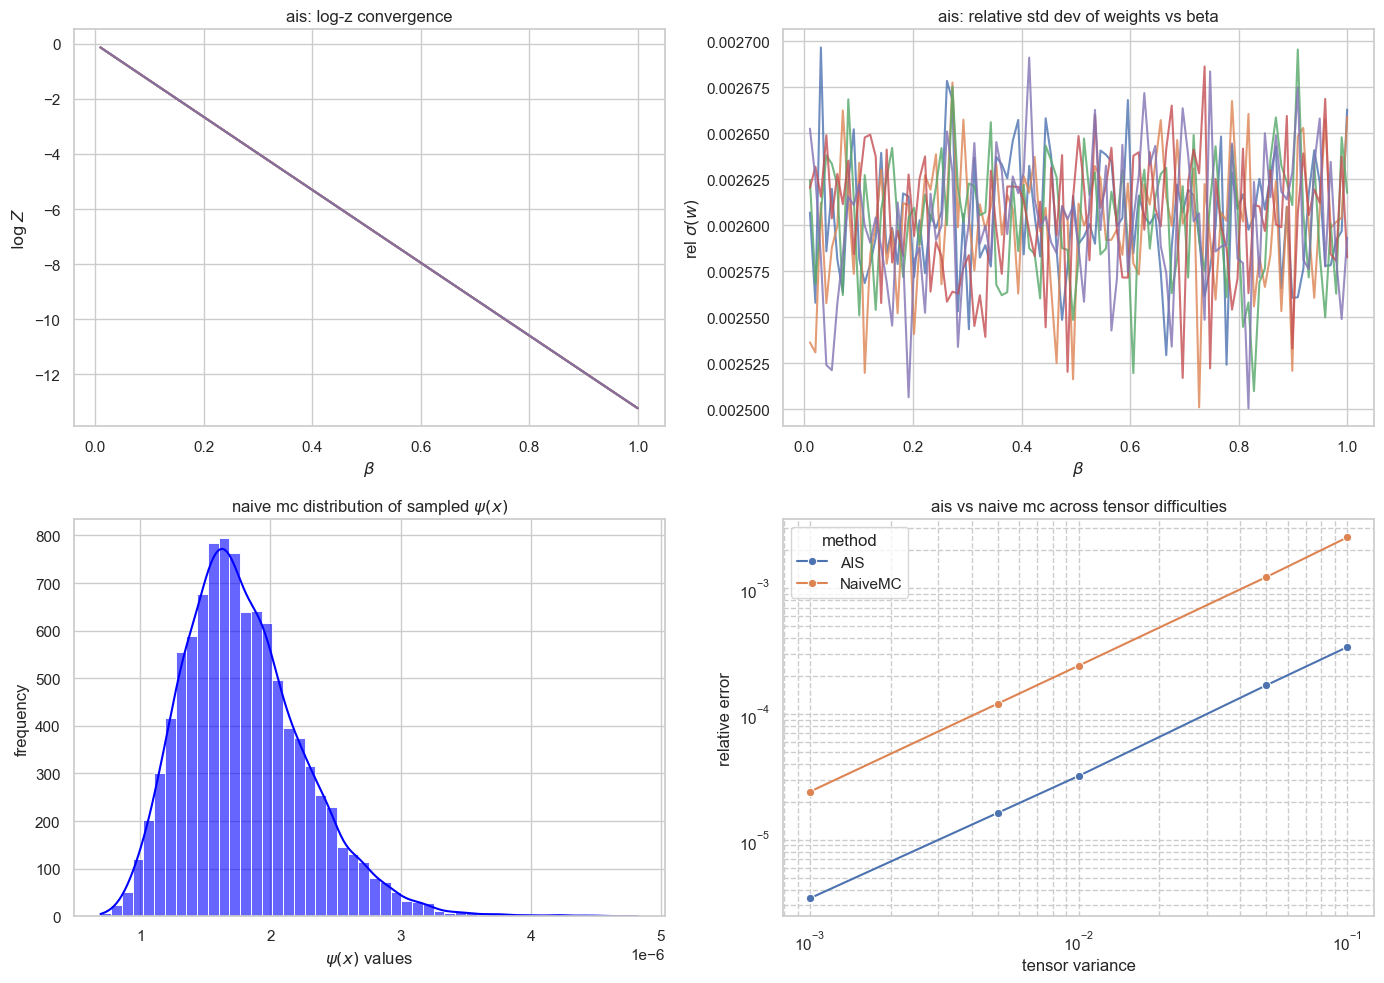


================== final summary ==================
true Z               : 0.958244
ais estimate         : 0.958569 ± 0.000755
naive mc estimate    : 0.955825 ± 0.000000
relative error (ais) : 0.033911%
relative error (mc)  : 0.252361%


In [14]:
def run_variance_sweep(variances, dim=3, n_betas=100, n_chains=5, iters=20000, burns=1900, mc_samples=10000):
    rows = []
    for variance in variances:
        print(f"\n>>> running trial with tensor variance = {variance}")
        G, tensors = build_3x3_grid_test(dim=dim, variance=variance)
        TRUE_Z = contract_tensor_network(G, tensors)
        tn = TensorNetwork(G, tensors)
        betas = np.linspace(0, 1, n_betas)

        # run AIS
        Z_ais, _, _ = estimate_contraction(tn, betas, iters, burns, n_chains=n_chains, verbose=False)
        ais_mean, ais_std = np.mean(Z_ais), np.std(Z_ais)
        rel_ais = abs(ais_mean - TRUE_Z) / abs(TRUE_Z)

        # run naive MC
        mc_estimate, _, mc_values = naive_mc_estimate(tn, num_samples=mc_samples, Z_true=TRUE_Z, seed=42)
        mc_std = np.std(mc_values) / np.sqrt(len(mc_values))
        rel_mc = abs(mc_estimate - TRUE_Z) / abs(TRUE_Z)

        # save results
        rows.extend([
            {"variance": variance, "method": "AIS", "mean_Z": ais_mean, "std_Z": ais_std, "rel_error": rel_ais},
            {"variance": variance, "method": "NaiveMC", "mean_Z": mc_estimate, "std_Z": mc_std, "rel_error": rel_mc},
        ])

    return pd.DataFrame(rows)

def test_compare_ais_vs_naive_mc(dim=3,
                                 n_betas=100,
                                 n_chains=5,
                                 iters=20000,
                                 burns=1900,
                                 mc_samples=10000,
                                 variances=[0.001, 0.005, 0.01, 0.05, 0.1]):
    print("\n>>> building 3x3 tensor network for ais vs naive mc comparison")
    G, tensors = build_3x3_grid_test(dim=dim)
    TRUE_Z = contract_tensor_network(G, tensors)
    print(f'true Z (exact contraction): {TRUE_Z:.6f}')

    tn = TensorNetwork(G, tensors)
    betas = np.linspace(0, 1, n_betas)

    print('\n>>> running ais estimation')
    Z_ais, logZ_trajs, weights_by_beta = estimate_contraction(
        tn, betas, iters, burns, n_chains=n_chains, verbose=True
    )
    ais_mean, ais_std = np.mean(Z_ais), np.std(Z_ais)

    # run naive mc estimation
    print('\n>>> running naive mc estimation')
    mc_estimate, mc_error, mc_values = naive_mc_estimate(
        tn, num_samples=mc_samples, Z_true=TRUE_Z, seed=42
    )
    mc_std = np.std(mc_values) / np.sqrt(len(mc_values))
    mc_mean = mc_estimate

    # run performance sweep across tensor variances
    print('\n>>> running variance sweep for ais vs naive mc')
    results_df = run_variance_sweep(variances=variances,
                                        dim=dim,
                                        n_betas=n_betas,
                                        n_chains=n_chains,
                                        iters=iters,
                                        burns=burns,
                                        mc_samples=mc_samples)
    
    # plotting comparison
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    sns.set_theme(style="whitegrid")

    # log-z convergence plot
    for i, traj in enumerate(logZ_trajs):
        axs[0, 0].plot(betas[1:], traj, label=f'chain {i+1}', alpha=0.8)
    axs[0, 0].set_title('ais: log-z convergence')
    axs[0, 0].set_xlabel(r'$\beta$')
    axs[0, 0].set_ylabel(r'$\log Z$')

    # weight dispersion
    for i in range(n_chains):
        rel_std = [np.std(w[i]) / np.mean(w[i]) if np.mean(w[i]) > 0 else 0 for w in weights_by_beta]
        axs[0, 1].plot(betas[1:], rel_std, label=f'chain {i+1}', alpha=0.8)
    axs[0, 1].set_title('ais: relative std dev of weights vs beta')
    axs[0, 1].set_xlabel(r'$\beta$')
    axs[0, 1].set_ylabel(r'rel $\sigma(w)$')

    # naive mc histogram
    sns.histplot(mc_values, bins=50, kde=True, ax=axs[1, 0], color='blue', alpha=0.6)
    axs[1, 0].set_title('naive mc distribution of sampled $\psi(x)$')
    axs[1, 0].set_xlabel(r'$\psi(x)$ values')
    axs[1, 0].set_ylabel('frequency')

    # variance vs error (log-log plot)
    sns.lineplot(data=results_df, x='variance', y='rel_error', hue='method', ax=axs[1, 1], marker='o')
    axs[1, 1].set_title('ais vs naive mc across tensor difficulties')
    axs[1, 1].set_xlabel('tensor variance')
    axs[1, 1].set_ylabel('relative error')
    axs[1, 1].set_xscale('log')
    axs[1, 1].set_yscale('log')
    axs[1, 1].legend(title='method')
    axs[1, 1].grid(True, which='both', linestyle='--')

    plt.tight_layout()
    plt.show()

    print("\n================== final summary ==================")
    print(f"true Z               : {TRUE_Z:.6f}")
    print(f"ais estimate         : {ais_mean:.6f} ± {ais_std:.6f}")
    print(f"naive mc estimate    : {mc_mean:.6f} ± {mc_std:.6f}")
    print(f"relative error (ais) : {abs(ais_mean - TRUE_Z) / abs(TRUE_Z):.6%}")
    print(f"relative error (mc)  : {abs(mc_mean - TRUE_Z) / abs(TRUE_Z):.6%}")
    print("====================================================")

test_compare_ais_vs_naive_mc(dim=3,
                            n_betas=100,
                            n_chains=5,
                            iters=20000,
                            burns=1900,
                            mc_samples=10000)